In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
# Expected columns:
# ['timestamp','open','high','low','close','volume']
df = pd.read_csv("../data/binance/hbar.csv", parse_dates=["time_stamp"])
df = df.sort_values("time_stamp").set_index("time_stamp")

In [ ]:
# fetaures
df["log_return"] = np.log(df["close"] / df["close"].shift(1))

# aggregate to daily
daily = pd.DataFrame()

daily = df.resample('D').agg({
    'open': 'first',
    'close': 'last',
    'high': 'max',
    'low': 'min',
    'volume': 'sum',
    'quote_volume': 'sum',
    'taker_base_volume': 'sum',
    'taker_quote_volume': 'sum',
    'trades': 'sum'
})

# Returns
daily["intraday_return"] = np.log(daily["close"] / daily["open"])
daily["range"] = (daily["high"] - daily["low"]) / daily["open"]

# Volatility from hourly returns
daily["volatility"] = (
    df["log_return"]
    .resample("1D")
    .std()
)

# Late-session momentum (last 6 hours)
late = df.between_time("18:00", "23:00")
daily["late_return"] = (
    late["log_return"]
    .resample("1D")
    .sum()
)

# Trend persistence
daily["trend_persistence"] = (
    df["log_return"]
    .resample("1D")
    .apply(lambda x: np.mean(np.sign(x)))
)

features = [
    "intraday_return",
    "range",
    "volatility",
    "late_return",
    "trend_persistence",
    "volume"
]
# other features
other_features_1 = True
if other_features_1:
    daily['yesterday_bullish_bearish'] = np.where(daily['close'] > daily['open'], 1, 0)
    daily['volume_change_pct'] = daily['volume'].pct_change()
    #daily['log_return'] = np.log(daily['close'] / daily['close'].shift(1))
    daily['log_high_low'] = np.log(daily['high'] / daily['low'])
    daily['true_range_1'] = daily['high'] - daily['low']
    daily['true_range_2'] = abs(daily['high'] - daily['open'])
    daily['true_range_3'] = abs(daily['low'] - daily['open'])
    daily['true_range_4'] = abs(daily['high'] - daily['close'])
    daily['true_range_5'] = abs(daily['low'] - daily['close'])
    features += [
        'yesterday_bullish_bearish',
        'volume_change_pct',
        'log_high_low',
        'true_range_1',
        'true_range_2',
        'true_range_3',
        'true_range_4',
        'true_range_5'
        ]

other_features_2 = False
if other_features_2:
    delta = daily['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    # Preserve index by using daily.index when creating Series
    avg_gain = pd.Series(gain, index=daily.index).rolling(window=7).mean()
    avg_loss = pd.Series(loss, index=daily.index).rolling(window=7).mean()
    rs = avg_gain / avg_loss
    daily['rsi_7'] = 100 - (100 / (1 + rs))
    # Moving Average Convergence Divergence
    ema_7 = daily['close'].ewm(span=7, adjust=False).mean()
    ema_14 = daily['close'].ewm(span=14, adjust=False).mean()
    daily['macd'] = ema_7 - ema_14
    daily['macd_signal'] = daily['macd'].ewm(span=3, adjust=False).mean()

    # Average True Range
    high_low = daily['high'] - daily['low']
    high_close = np.abs(daily['high'] - daily['close'].shift())
    low_close = np.abs(daily['low'] - daily['close'].shift())
    daily['tr'] = high_low.combine(high_close, max).combine(low_close, max)
    daily['atr_7'] = daily['tr'].rolling(window=7).mean()

    # Bollinger Bands
    #daily['bb_middle'] = daily['close'].rolling(20).mean()
    #daily['bb_std'] = daily['close'].rolling(10).std()
    #daily['bb_upper'] = daily['bb_middle'] + 2 * daily['bb_std']
    #daily['bb_lower'] = daily['bb_middle'] - 2 * daily['bb_std']

    # Volume moving average
    daily['vol_sma_20'] = daily['volume'].rolling(window=10).mean()

    features += [
        'rsi_7',
        'macd',
        'macd_signal',
        'atr_7',
        #'bb_middle',
        #'bb_upper',
        #'bb_lower',
        'vol_sma_20'
    ]

daily = daily.dropna()

# label
epsilon = 0.0005  # cost + noise buffer

future_return = np.log(daily["close"].shift(-1) / daily["close"])

daily["y"] = np.where(
    future_return > epsilon, 1,
    np.where(future_return < -epsilon, 0, np.nan)
)

daily = daily.dropna()

In [15]:
# train/test
X = daily[features]
y = daily["y"]

split = int(len(X) * 0.5)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

scaling_needed = False
if scaling_needed:  
    # columns to scale - use the features list already defined
    cols_to_scale = features

    # scaler
    scaler = StandardScaler()

    # fit scaler on training data
    X_train.loc[:, cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

    # transform test data
    X_test.loc[:, cols_to_scale] = scaler.transform(X_test[cols_to_scale])
# model
model = HistGradientBoostingClassifier(random_state=18,
                                       max_iter=200,
                                       max_depth=10,
                                       min_samples_leaf=20,
                                       learning_rate=0.05,
                                       early_stopping=True,
                                       validation_fraction=0.5)
model.fit(X_train, y_train)


,"loss loss: {'log_loss'}, default='log_loss'The loss function to use in the boosting process.For binary classification problems, 'log_loss' is also known as logistic loss,binomial deviance or binary crossentropy. Internally, the model fits one treeper boosting iteration and uses the logistic sigmoid function (expit) asinverse link function to compute the predicted positive class probability.For multiclass classification problems, 'log_loss' is also known as multinomialdeviance or categorical crossentropy. Internally, the model fits one tree perboosting iteration and per class and uses the softmax function as inverse linkfunction to compute the predicted probabilities of the classes.",'log_loss'
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.05
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees for binary classification. For multiclassclassification, `n_classes` trees per iteration are built.",200
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",31
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",10
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",20
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.0
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide `... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged:: 1.4 Added `""from_dtype""` option... versionchanged:: 1.6 The default value changed from `None` to `""from_dtype""`.",'from_dty

-----------Train-----------

AUC Score 0.6667278063096111 

              precision    recall  f1-score   support

         0.0       0.61      0.80      0.69       188
         1.0       0.68      0.44      0.53       174

    accuracy                           0.63       362
   macro avg       0.64      0.62      0.61       362
weighted avg       0.64      0.63      0.62       362


-----------Test-----------

AUC Score 0.4826644575355915 

              precision    recall  f1-score   support

         0.0       0.52      0.66      0.58       194
         1.0       0.43      0.30      0.35       168

    accuracy                           0.49       362
   macro avg       0.48      0.48      0.47       362
weighted avg       0.48      0.49      0.48       362



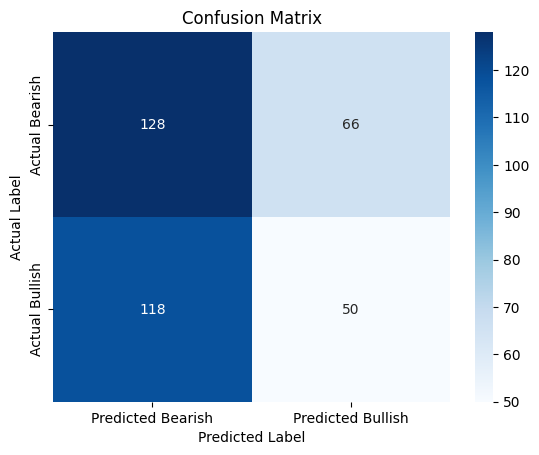

In [16]:
print('-----------Train-----------\n')
thr = 0.5
y_train_pred_proba = model.predict_proba(X_train)
print(f'AUC Score {roc_auc_score(y_train, y_train_pred_proba[:, 1])} \n')
y_train_pred = np.where(y_train_pred_proba[:, 1] >= thr, 1, 0)  # Try 0.55, 0.6, or even 0.65
print(classification_report(y_train, y_train_pred))
print('\n-----------Test-----------\n')
y_pred_prob = model.predict_proba(X_test)[:, 1]
print(f'AUC Score {roc_auc_score(y_test, y_pred_prob)} \n')
# Lower threshold to predict more bearish (increase bearish recall)
y_pred = np.where(y_pred_prob >= thr, 1, 0)  # Try 0.55, 0.6, or even 0.65
print(classification_report(y_test, y_pred))

# heatmap of confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Bearish', 'Predicted Bullish'], yticklabels=['Actual Bearish', 'Actual Bullish'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# signal creation
daily.loc[X_test.index, "P_up"] = y_pred_prob

daily["signal"] = 0
daily.loc[daily["P_up"] > 0.55, "signal"] = 1
daily.loc[daily["P_up"] < 0.45, "signal"] = -1

# signal:
#  1  = long
# -1  = short
#  0  = no trade